### Work division
#### The work for this notebook is done and compiled by Nemish Murawat.

### Libraries Required

In [1]:
# Import Requirements
import pandas as pd
from tqdm import tqdm as tq
import numpy as np
import matplotlib.pyplot as plt
import datetime
from collections import Counter

Matplotlib is building the font cache; this may take a moment.


### Bonus B
## Assume users publish their posts the same day pictures or videos are taken: Are there users that have visited the same location on the same day? How about the same week? Extract the results and explain them.

### *Flow of Execution*:

#### - To answer the given question, I use three datasets to evaluate the required subparts of the questions. 
#### - I find those users which are present in *Instagram_Profiles.csv* and they have atleast one post in the *Instagram_Posts.csv* dataset. Further I filter those posts whose location-id is not present in the *Instagram_location.csv* dataset.

#### Step-1: 
##### - I read the complete Location dataset( Just one column containing Location-ID) in one-go  as the size of the dataset is not that big. 
##### - I drop rows with any NaN value present

In [2]:

df_locations=pd.read_csv('/home/ec2-user/SageMaker/Data/instagram_locations.csv',usecols=['id'],sep='\t')
df_locations=df_locations.dropna()

#### Step-2: 
##### - I read the complete Profiles dataset( Just one column containing SID) in one-go  as the size of the dataset is not that big. 
##### - I drop rows with any NaN value present

In [3]:

df_profiles=pd.read_csv('/home/ec2-user/SageMaker/Data/instagram_profiles.csv',usecols=['sid'],sep='\t')
df_profiles=df_profiles.dropna()

#### Step-3: 
##### - I read the Posts dataset( Columns='profile_id','location_id','cts') in chunks due to the large datasize of the dataset
##### - I drop rows with any NaN value present
##### - For every Chunk I perform three operations:
> ######    I merge Chunk and Location dataset on those Location_id which are present in both the dataframe
> ######    I find those users which are present in both the previously-merged dataframe and Profile dataset. In the end I get users whose required information is present in all datasets.
> ######    I Concatenate the Final merged Dataframe(df_merged) for all the chunks and would use this for further analysis.


In [ ]:

for i,chunk in tq(enumerate(pd.read_csv('/home/ec2-user/SageMaker/Data/instagram_posts.csv',sep='\t',usecols=['profile_id','location_id','cts'],chunksize=100000,keep_default_na=True))):
           chunk=chunk.dropna()
           df_final=pd.merge(chunk,df_locations,left_on='location_id',right_on='id')
           df_final=pd.merge(df_final,df_profiles,left_on='profile_id',right_on='sid')
           df_final=df_final.drop(['id','sid'],axis=1)
           df_merged=pd.concat([x,df_final],axis=0) if i!=0 else df_final

428it [1:20:05, 11.23s/it]


#### Step-4: Further modifying the Dataframe
##### - I convert the string Timestamps in (cts) column to datetime objects to be able to use the data more efficiently.
##### - I create two new more columns to get date and time from the Datetime objects created for every user.



In [65]:
#df_merged=pd.read_csv('/home/ec2-user/SageMaker/Data/Three_intersection.csv')
df_merged['cts']=pd.to_datetime(df_merged['cts'])
df_merged['date']=pd.DatetimeIndex(df_merged['cts']).date
df_merged['time']=pd.DatetimeIndex(df_merged['cts']).time


#### Step-5: Towards finding users who would have visited the locations on Same-day
##### - I create a Counter(c) over the Location-Id which helps me to identify:
> ###### Number of distinct Location
##### - I Iterate over the key values(distinct locations) of the counter
> ###### I find those rows with the jth Location-ID to get the users visiting the location(df_location)
> ###### I create a counter(c1) over the possible dates for that location visited by the user.
##### - Now I Iterate over the possible dates of that Location-ID
> ###### Now,using the df_location dataframe I find those rows(users) which have visited that location on that day (df_location_date).
> ###### I create a counter(c2) over all the possible users('Profile_ID') that would a visited a particular location on a particular date.
> ###### I store those users in a dictionary(location_date) for which I can get a more than one-users for a location and on a particular date. The format for the stored dictionary:
>>###### Key: Location Value: [ Date, Counter_Object( Key: Profile_id, Value: Number of time the user visited the location on that day)]



In [66]:
c=Counter(df_merged['location_id'].values)
location_date={}
for i,j in tq(enumerate(c.keys())):
    df_location=df_merged[df_merged['location_id']==j]
    c1=Counter(df_location['date'].values)
    
    for k in c1.keys():
        df_location_date=df_location[df_location['date']==k]
        c2=Counter(df_location_date['profile_id'])
        
        if (len(location_date)==0) and ((sum(c2.values())>1) and (len(c2)>1)): 
            location_date={j:[[k,dict(c2)]]}
            
        elif (j not in location_date.keys()) and ((sum(c2.values())>1) and (len(c2)>1)):
            location_date[j]=[[k,dict(c2)]]
            
        elif ((sum(c2.values())>1) and (len(c2)>1)):
            location_date[j].append([k,dict(c2)])

                

218115it [07:06, 511.90it/s]


#### Step-6: Towards finding users who would have visited the locations on Same-day
##### - I convert the stored dictionary into Dataframe(df_location) with Columns: Location_id','Date','n_users'
##### - I create a new Column: Count to get the actual value of users that have visited a particular location on a given date.

In [67]:
df_location=pd.DataFrame([(k,*x) for k,v in location_date.items() for x in v ],columns=['Location_id','Date','n_users'])
count=[]
for i,j in tq(enumerate(df_location['n_users'])):

        count.append(len(j))
df_location['Count']=count
df_location

11416it [00:00, 876882.60it/s]


,Location_id,Date,n_users,Count
0,1.355426e+15,2019-06-03,"{138932.0: 1, 1873096.0: 1}",2
1,1.957827e+15,2019-05-25,"{311771.0: 1, 2750189.0: 1}",2
2,3.226783e+08,2019-05-09,"{632129.0: 1, 650406.0: 2}",2
3,2.696303e+08,2019-05-30,"{3465032.0: 1, 2234616.0: 2}",2
4,1.276207e+14,2019-05-05,"{1661025.0: 1, 4125475.0: 1}",2
...,...,...,...,...
11411,6.252645e+08,2018-07-14,"{3568917.0: 1, 2689816.0: 1}",2
11412,3.818394e+08,2019-05-29,"{3866899.0: 1, 1007994.0: 1}",2
11413,5.180815e+08,2016-05-06,"{2772195.0: 1, 3164283.0: 1}",2
11414,2.567200e+05,2019-05-25,"{1801359.0: 1, 1227933.0: 1}",2


#### Step-7: Towards finding users who would have visited the locations on Same-day
##### - I Calculate the total counts of users that have visited a location on the same day

In [69]:
People_same_day=0
for i,j in enumerate(df_location['n_users']):
  
        People_same_day += len(j)


In [70]:
print('The Number of users that have visited a location on the same day is {}'.format(People_same_day))

The Number of users that have visited a location on the same day is 32388


#### Step-8: Scatter plot of users that have visited a location on the same day

Text(0, 0.5, 'No. of users went within a same day of Posting')

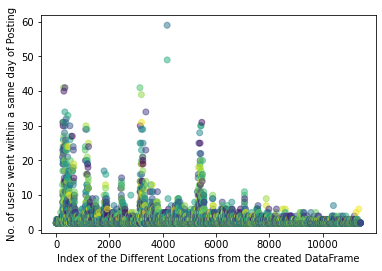

In [71]:

colors=np.random.rand(len(df_location['Location_id'].values))
plt.scatter(y=df_location['Count'].values,x=df_location.index,alpha=0.5,c=colors)
plt.xlabel('Index of the Different Locations from the created DataFrame')
plt.ylabel('No. of users went within a same day of Posting')

#### Step-9: Towards finding users who would have visited the locations within a same week
##### - I create a Counter(c) over the Location-Id which helps me to identify:
> ###### Number of distinct Location
##### - I Iterate over the key values(distinct locations) of the counter
> ###### I find those rows with the jth Location-ID to get the users visiting the location(df_location)
> ###### I create a counter(c1) over the possible dates for that location visited by the user.
##### - Now I Iterate over the possible dates of that Location-ID
> ###### Now,using the df_location dataframe I find those rows(users) which have visited that location on that day (df_location_date).
> ###### I create a counter(c2) over all the possible users('Profile_ID') that would a visited a particular location on a particular date.
> ###### I store those users in a dictionary(location_date) for which I can get with a least one-users for a location and on a particular day.
>>###### The reason to include with a location(on a particular date) with just one user as he might have gone to visit the location within span of one-week of others users.
>>###### The format for the stored dictionary:Key: Location Value: [ Date, Counter_Object( Key: Profile_id, Value: Number of time the user visited the location on that day)]



In [72]:
c=Counter(df_merged['location_id'].values)
location_date_1={}
for i,j in tq(enumerate(c.keys())):
    
    df_location=df_merged[df_merged['location_id']==j]
    c1=Counter(df_location['date'].values)
    
    for k in c1.keys():
        
        df_location_date=df_location[df_location['date']==k]
        c2=Counter(df_location_date['profile_id'])
        
        if (len(location_date_1)==0) and ((sum(c2.values())>0) and (len(c2)>0)): 
            location_date_1={j:[[k,dict(c2)]]}
            
        elif (j not in location_date_1.keys()) and ((sum(c2.values())>0) and (len(c2)>0)):
            location_date_1[j]=[[k,dict(c2)]]
            
        elif ((sum(c2.values())> 0) and (len(c2)>0)):
            location_date_1[j].append([k,dict(c2)])

                

218115it [06:59, 519.83it/s]


#### Step-10: Towards finding users who would have visited the locations within a same week
##### - I convert the stored dictionary into Dataframe(df_location) with Columns: Location_id','Date','n_users'
##### - I sort the Dataframe using columns: [Date and Location_id] to get dataframe in orders of location_id and in orders of visit for that location.
##### - Now, I take difference of consecutive rows for columns ['location_id' and 'date'] and add them as columns to the dataframe.
#####  - Copy DataFrame(df_location_1) to df_location_2. 

In [73]:
##Within a week
df_location_1=pd.DataFrame([(k,*x) for k,v in location_date_1.items() for x in v ],columns=['Location_id','Date','n_users'])
df_location_1=df_location_1.sort_values(['Location_id','Date'],ascending=[True,True])
df_location_2=df_location_1[['Location_id','Date']]
df_location_1['diff_loc']=df_location_2.diff()['Location_id']
df_location_1['diff_Date']=df_location_2.diff()['Date']
df_location_2=df_location_1

#### Step-11: Towards finding users who would have visited the locations within a same week
##### -Using the diff_Date column , a create a new column [Days] as datatype int to make easier instead of using datetime objects
>###### - The aim of sorting and taking difference was to get time difference between posts between users time of posting which would facilitate in finding the users according to the given constraint.
##### - Note the first row contains NaN values as for pandas.diff() method I need two rows to calculate the required values.

In [74]:
def get_date(x):
    try:
        return x.days
    except:
        return np.NaN

x=df_location_2['diff_Date'].apply(get_date)
df_location_2['Days']=x
df_location_2

,Location_id,Date,n_users,diff_loc,diff_Date,Days
143549,1.000000e+01,2011-02-16,{957640.0: 1},NaN,NaN,NaN
143551,1.000000e+01,2016-11-06,{1060749.0: 1},0.000000e+00,"2090 days, 0:00:00",2090.0
143550,1.000000e+01,2017-09-02,{3591211.0: 1},0.000000e+00,"300 days, 0:00:00",300.0
328787,4.600000e+01,2014-11-24,{1359813.0: 1},3.600000e+01,"-1013 days, 0:00:00",-1013.0
328786,4.600000e+01,2017-04-10,{1813011.0: 1},0.000000e+00,"868 days, 0:00:00",868.0
...,...,...,...,...,...,...
211870,3.163097e+15,2019-03-29,{2563910.0: 1},0.000000e+00,"4 days, 0:00:00",4.0
336287,3.373913e+15,2019-02-21,{672004.0: 1},2.108156e+14,"-36 days, 0:00:00",-36.0
40432,3.846355e+15,2016-10-30,{3384228.0: 1},4.724419e+14,"-844 days, 0:00:00",-844.0
294510,6.417260e+15,2019-05-05,{4197510.0: 2},2.570905e+15,"917 days, 0:00:00",917.0


#### Step-12: Towards finding users who would have visited the locations within a same week
##### In this part from the created df_location_2 I use boolean logic to find users:
>###### -Those rows for different location_id which would have day_difference between [0 and 7] 
>###### -Further to filter out, I use diff_loc value to find users with same location_id and would have posted with a span of week.
##### The results are outputed in the Dataframe x

In [75]:
x=df_location_2[(df_location_2['Days']>0) & (df_location_2['Days']<=7)] 
x=x[x['diff_loc']==0]
x

,Location_id,Date,n_users,diff_loc,diff_Date,Days
174402,1.410000e+02,2019-05-26,{990964.0: 1},0.0,"4 days, 0:00:00",4.0
237341,3.890000e+02,2019-02-24,{980862.0: 1},0.0,"7 days, 0:00:00",7.0
237338,3.890000e+02,2019-02-25,{1328827.0: 1},0.0,"1 day, 0:00:00",1.0
237337,3.890000e+02,2019-03-04,{430384.0: 1},0.0,"7 days, 0:00:00",7.0
237339,3.890000e+02,2019-03-08,{4258005.0: 1},0.0,"4 days, 0:00:00",4.0
...,...,...,...,...,...,...
281628,2.881182e+15,2019-04-25,{1006094.0: 2},0.0,"2 days, 0:00:00",2.0
375929,2.937459e+15,2019-04-07,{3456134.0: 1},0.0,"7 days, 0:00:00",7.0
375928,2.937459e+15,2019-04-14,{3456134.0: 1},0.0,"7 days, 0:00:00",7.0
212974,3.005502e+15,2019-02-26,{3317714.0: 1},0.0,"1 day, 0:00:00",1.0


#### Step-13: Towards finding users who would have visited the locations within a same week
##### - Now if we have a closely look on the final rows in x. Each value in x['Days'] corresponds to difference in consecutive rows in df_location_2 dataset.
##### - Hence, to get rows which statisfy the condition of same location_id and difference between time_stamps of being less <= 7.I use the index of x and get [j-1,j] rows from df_location_2 dataset.
>##### - Note of caution would that there might be a case that three consecutive rows follow this constraint and I would have already added the first two rows information in dictionary.
>##### - Hence,I check if the j-1 row has already been added or not.

##### - Structure of same_week: key: Index of df_location_2, Value:[Location_id, Counter of users on a particular date]


In [76]:
Same_week={}
for i,j in tq(enumerate(x.index)):
    if i==0:
        Same_week={j-1:[df_location_2.loc[j-1]['n_users'],df_location_2.loc[j-1]['Location_id']],j:[df_location_2.loc[j]['n_users'],df_location_2.loc[j]['Location_id']]}
    else:
        if j-1 in Same_week.keys():
            Same_week[j]=[df_location_2.loc[j]['n_users'],df_location_2.loc[j]['Location_id']]
        else:
            Same_week[j-1]=[df_location_2.loc[j-1]['n_users'],df_location_2.loc[j-1]['Location_id']]
            Same_week[j]=[df_location_2.loc[j]['n_users'],df_location_2.loc[j]['Location_id']]

69333it [00:28, 2454.25it/s]


#### Step-14: Towards finding users who would have visited the locations within a same week
##### - I convert the same_week dictionary to df_location_week dataframe

In [80]:

df_location_week=pd.DataFrame([(k,v[0],v[1]) for k,v in Same_week.items()],columns=['Index','n_users','Location_id',])
df_location_week=df_location_week.set_index(df_location_week.iloc[:,0])
df_location_week

                      

,Index,n_users,Location_id
Index,,,
174401,174401,{2426274.0: 1},1.410000e+02
174402,174402,{990964.0: 1},1.410000e+02
237340,237340,{4726.0: 1},3.890000e+02
237341,237341,{980862.0: 1},3.890000e+02
237337,237337,{430384.0: 1},3.890000e+02
...,...,...,...
375927,375927,{563442.0: 1},2.937459e+15
212973,212973,{118153.0: 1},2.378219e+08
212974,212974,{3317714.0: 1},3.005502e+15


#### Step-14: Towards finding users who would have visited the locations within a same week
##### - I group the rows with same location-id and aggregate all the 'n_user' into a list. 
>###### -Each row represents all the users who would have visited that location with a same week

In [81]:
df_location_week=df_location_week.groupby('Location_id')['n_users'].apply(list).reset_index(name='All the users who went within a week to that location')
df_location_week

,Location_id,All the users who went within a week to that location
0,1.410000e+02,"[{2426274.0: 1}, {990964.0: 1}]"
1,3.480000e+02,[{4110732.0: 1}]
2,3.890000e+02,"[{4726.0: 1}, {980862.0: 1}, {430384.0: 1}, {1..."
3,6.450000e+02,"[{1805926.0: 1}, {1805926.0: 1}]"
4,6.730000e+02,"[{1173802.0: 2}, {1173802.0: 1}, {720909.0: 1}..."
...,...,...
38192,3.005502e+15,"[{3317714.0: 1}, {3317714.0: 1}]"
38193,3.048956e+15,[{1655843.0: 1}]
38194,3.061592e+15,[{81044.0: 1}]
38195,3.163097e+15,[{2563910.0: 1}]


#### Step-14: Towards finding users who would have visited the locations within a same week
##### - I add a new column[Count] in df_location_week to calculate the users more explicity.


In [82]:
count=[]
for i,j in tq(enumerate(df_location_week['All the users who went within a week to that location'])):
        x=0
        for v in j:
            x += len(v)
        count.append(x)
df_location_week['Count']=count

df_location_week

38197it [00:00, 319519.25it/s]


,Location_id,All the users who went within a week to that location,Count
0,1.410000e+02,"[{2426274.0: 1}, {990964.0: 1}]",2
1,3.480000e+02,[{4110732.0: 1}],1
2,3.890000e+02,"[{4726.0: 1}, {980862.0: 1}, {430384.0: 1}, {1...",6
3,6.450000e+02,"[{1805926.0: 1}, {1805926.0: 1}]",2
4,6.730000e+02,"[{1173802.0: 2}, {1173802.0: 1}, {720909.0: 1}...",7
...,...,...,...
38192,3.005502e+15,"[{3317714.0: 1}, {3317714.0: 1}]",2
38193,3.048956e+15,[{1655843.0: 1}],1
38194,3.061592e+15,[{81044.0: 1}],1
38195,3.163097e+15,[{2563910.0: 1}],1


In [83]:
print('The Number of users that have visited a location on the same day is {}'.format(df_location_week['Count'].sum()))

The Number of users that have visited a location on the same day is 124132


#### Step-15: Scatter plot of users that have visited a location within a same week

Text(0, 0.5, 'No. of users went within a span of week')

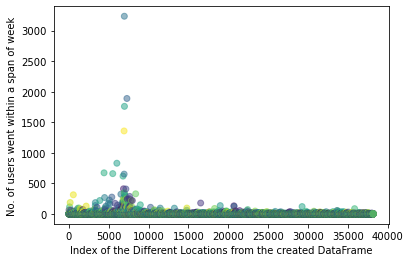

In [84]:

colors=np.random.rand(len(df_location_week['Location_id'].values))
plt.scatter(y=df_location_week['Count'].values,x=df_location_week.index,alpha=0.5,c=colors)
plt.xlabel('Index of the Different Locations from the created DataFrame')
plt.ylabel('No. of users went within a span of week')

#### Comments:
1. We can see that the influence of users posting about a particular location results in greater influence on the users(resulting them in going to the location) with number of days.
2. For the first case, I found that 32388 users have visited the locations on same day. In a way,I kind of draw onservation that users who might have seen other users post might have been influenced and went to check out that location
3. For the second case, I found that 124132 users have visited the location in same week. This number is more than the 1st Case which reflects that increase in influence of the posts over other users towards that location with span of time.
4. The total number of users considered in the analysis are 456918. 
